In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b100dtxt/glove.6B.100d.txt
/kaggle/input/sms-spam-collection-dataset/spam.csv


In [2]:
import re
import string
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from collections import Counter, defaultdict
from tqdm import tqdm

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import spacy
from spacy.util import compounding, minibatch

from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, Embedding, BatchNormalization, Dense, 
                         TimeDistributed, Dropout, Bidirectional, Flatten, GlobalMaxPool1D)
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                             classification_report, accuracy_score, confusion_matrix)

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam as tf_Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint as tf_ModelCheckpoint

import transformers
from tqdm.notebook import tqdm as notebook_tqdm
from tokenizers import BertWordPieceTokenizer

warnings.filterwarnings("ignore")
%matplotlib inline

2025-06-11 15:40:29.513430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749656429.718944      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749656429.778573      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Loading the SMS Spam Classification Dataset

In [4]:
df = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv",encoding='latin-1')
df = df.rename(columns={'v1': 'label', 'v2': 'message'})
df = df[['label', 'message']]
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Feature Engineering
- Adding Message Length Column

In [5]:
df['message_length'] = df['message'].apply(lambda x: len(x.split()))
df.head()

,label,message,message_length
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [6]:
balance_counts = df.groupby('label')['label'].agg('count')
balance_counts

label
ham     4825
spam     747
Name: label, dtype: int64

## EDA (Exploratory Data Analysis)

In [7]:
fig = go.Figure(
    data=[
        go.Bar(
            x=balance_counts.index,
            y=balance_counts.values,
            text=balance_counts.values,
            textposition='auto',
        )
    ]
)
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)
fig.show()

In [8]:
ham_df = df[df['label'] == 'ham']['message_length'].value_counts().sort_index()
spam_df = df[df['label'] == 'spam']['message_length'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=ham_df.index,
    y=ham_df.values,
    name='ham',
    fill='tozeroy'
))
fig.add_trace(go.Scatter(
    x=spam_df.index,
    y=spam_df.values,
    name='spam',
    fill='tozeroy'
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Data Roles in Different Fields</span>'
)
fig.update_xaxes(range=[0, 70])
fig.show()

# 3 Data Preprocessing

## 3.1 Cleaning the `message` field

In [9]:
def clean_text(text):
    '''
    Clean the input text by performing the following steps:
    1. Convert text to lowercase.
    2. Remove text inside square brackets.
    3. Remove URLs (http, https, www).
    4. Remove HTML tags.
    5. Remove punctuation.
    6. Remove newline characters.
    7. Remove words containing numbers.
    '''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df['message_clean'] = df['message'].apply(clean_text)
df.head()

,label,message,message_length,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,11,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah i dont think he goes to usf he lives aroun...


## 3.4 Label Encoding

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['label'])

df['label_encoded'] = le.transform(df['label'])
df[['message_clean','label_encoded']].head()

,message_clean,label_encoded
0,go until jurong point crazy available only in ...,0
1,ok lar joking wif u oni,0
2,free entry in a wkly comp to win fa cup final...,1
3,u dun say so early hor u c already then say,0
4,nah i dont think he goes to usf he lives aroun...,0


## 5 Vectorization : CountVectorizer, TF-IDF

In [11]:
x = df['message_clean']
y = df['label_encoded']

print(len(x), len(y))

5572 5572


In [12]:
# Split into train and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.25,           # You can adjust the test size as needed
    random_state=42,
    stratify=y                # This ensures the class distribution is preserved
)

print(len(x_train), len(y_train))
print(len(x_test), len(y_test))
print("Train class distribution:\n", y_train.value_counts())
print("Test class distribution:\n", y_test.value_counts())

4179 4179
1393 1393
Train class distribution:
 label_encoded
0    3619
1     560
Name: count, dtype: int64
Test class distribution:
 label_encoded
0    1206
1     187
Name: count, dtype: int64


In [13]:
# We will be creating seaborn and plotly confusion matrices
import plotly.figure_factory as ff
x_axes = ['Safe','Spam']
y_axes = ['Spam', 'Safe']

def conf_matrix(z, x=x_axes, y=y_axes):
    z = np.flip(z, 0)
    # Change each element of z to string 
    # This allows them to be used as annotations
    z_str = [[str(y) for y in x] for x in z]
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_str)
    
    fig.update_layout(title_text='Confusion matrix', xaxis=dict(title='Predicted Value'),
                     yaxis=dict(title='Real value'))
    
    fig['data'][0]['showscale'] = True
    return fig

In [14]:
from sklearn.metrics import confusion_matrix
categories=['Safe', 'Spam']
def seaborn_conf(y, ypred):
    y_true = ["Safe", "Spam"]
    y_pred = ["Safe", "Spam"]
    cf = confusion_matrix(y, ypred)
    df_cm = pd.DataFrame(cf, columns=np.unique(y_true), index = np.unique(y_true))
    plt.figure(figsize=(8,6))
    sns.heatmap(df_cm, annot=True, fmt='g')
    plt.title('Confusion matrix')
    plt.xlabel('Predicted value')
    plt.ylabel('Real value')
    plt.show()

## Transformers - BERT

BERT has revolutionized the world of NLP by providing state-of-the-art results on many NLP tasks. BERT stands for Bidirectional Encoder Representation from Transformer. It is the state-of-the-art embedding model published by Google. It has created a major breakthrough in the field of NLP by providing greater results in many NLP tasks, such as question answering, text generation, sentence classification, and many more besides. One of the major reasons for the success of BERT is that it is a context-based embedding model, unlike other popular embedding models, such as word2vec, which are context-free.

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from transformers import RobertaTokenizer, TFRobertaModel
from tensorflow.keras.layers import Dense, Dropout, Input

from transformers import BertTokenizer, TFBertForQuestionAnswering
import tensorflow as tf

In [16]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the dataset
def tokenize_data(text_list, max_length=128):
    return tokenizer(
        text_list,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt')

train_encodings = tokenize_data(x_train.tolist())
test_encodings = tokenize_data(x_test.tolist())

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [17]:
# Convert labels to tensors
y_train = torch.tensor(y_train.values)
y_test = torch.tensor(y_test.values)

# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Training The Model

In [18]:
device

device(type='cuda')

In [19]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from tqdm import tqdm
import time

# Create a dataset object
train_dataset = TensorDataset(train_encodings['input_ids'], \
                              train_encodings['attention_mask'], y_train)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Set up the optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-5)

# Training loop
start = time.time()
epochs = 2
model.train()

for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}/{epochs}")
    for batch in tqdm(train_loader):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward Pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward Pass
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1} completed. Loss: {loss.item()}")
end = time.time()

print(f"Time taken: {end - start}")

Epoch: 1/2


100%|██████████| 262/262 [00:52<00:00,  5.02it/s]


Epoch 1 completed. Loss: 0.01267358660697937
Epoch: 2/2


100%|██████████| 262/262 [00:51<00:00,  5.08it/s]


Epoch 2 completed. Loss: 0.0015878955600783229
Time taken: 103.85827827453613


## Evaluate The Model

In [20]:
from torch.utils.data import DataLoader, TensorDataset

# Create a dataset object for testing
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [21]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch, sys

model.eval()

predictions = []
true_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, file=sys.stdout, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).flatten()
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

100%|██████████| 88/88
Model Accuracy: 98.56%


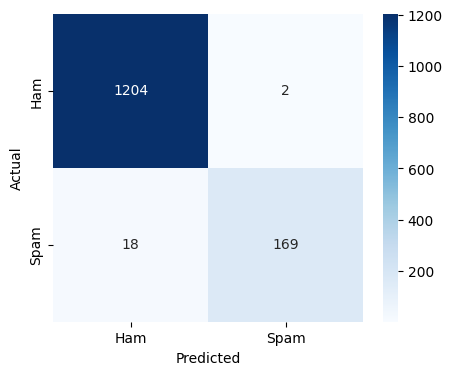

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions)
# Plot heatmap of confusion matrix with spam and not spam labels
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Classification Report

In [23]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1206
           1       0.99      0.90      0.94       187

    accuracy                           0.99      1393
   macro avg       0.99      0.95      0.97      1393
weighted avg       0.99      0.99      0.99      1393



## Saving The Model

In [24]:
from datetime import date
today = date.today()
date_string = today.strftime("%d-%m-%Y")


# To save model train on a GPU
trained_models_dir = '/kaggle/working/trained_models'
model.save_pretrained(f'{trained_models_dir}/bert-email-spam-classifier_tuned')
tokenizer.save_pretrained(f'{trained_models_dir}/bert-email-spam-classifier_tuned')

('/kaggle/working/trained_models/bert-email-spam-classifier_tuned/tokenizer_config.json',
 '/kaggle/working/trained_models/bert-email-spam-classifier_tuned/special_tokens_map.json',
 '/kaggle/working/trained_models/bert-email-spam-classifier_tuned/vocab.txt',
 '/kaggle/working/trained_models/bert-email-spam-classifier_tuned/added_tokens.json')

## Loading The Saved Model

In [25]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model_path = f'/kaggle/working/trained_models/bert-email-spam-classifier_tuned'

Using device: cuda


In [26]:
from transformers import BertTokenizer, BertForSequenceClassification

loaded_model = BertForSequenceClassification.from_pretrained(model_path)
loaded_tokenizer = BertTokenizer.from_pretrained(model_path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

loaded_model.to(device)

Using device: cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Make Prediction On New Data

In [27]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("SGHOSH1999/bert-email-spam-classifier_tuned")
model = AutoModelForSequenceClassification.from_pretrained("SGHOSH1999/bert-email-spam-classifier_tuned")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model.to(device)

tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Using device: cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [28]:
def predict_spam_with_loaded_model(text):
    model.eval()
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to GPU if available

    with torch.no_grad():
        logits = model(**inputs).logits
        prediction = torch.argmax(logits, dim=1).item()
        print(prediction)
    return 'Spam' if prediction == 1 else 'Not Spam'

In [29]:
spam_email = '''
Subject: Urgent attention required for best work

Urgent attention required for best work
Services:

    Udyam (MSME) Registration
    Import Export Code (IEC) Registration
    FSSAI Registration
    Trade Mark Registration
    PF Registration & Return Filing
    GST Return Filing
    80G & 12A Registration
    NGO DARPAN
    ISO Registration
    Startup India Registration
    CSR Registration

Warm Regards
Name - SUMIT TIWARI
Mobile - 8750906680
'''

ham_email = '''
Subject: Workday maintenance window
Hi All,
I would like to inform you about an upcoming Workday maintenance window that will result in temporary system blackouts over the next few days.
'''

In [30]:
print(predict_spam_with_loaded_model(spam_email))
print(predict_spam_with_loaded_model(ham_email))

0
Not Spam
0
Not Spam
